In [ ]:
import os
import pandas as pd
import requests
from tqdm import tqdm
import cv2
import time
import base64

from openai import OpenAI

# Set paths
BASE_PATH = "/kaggle/input/tammathon-task-3"
TEST_IMAGE_PATH = os.path.join(BASE_PATH, "test/test")
TEST_CSV_PATH = os.path.join(BASE_PATH, "test.csv")
VAL_IMAGE_PATH = os.path.join(BASE_PATH, "val/val")  # Validation image folder
VAL_CSV_PATH = os.path.join(BASE_PATH, "val.csv")    # Validation CSV

# Delay between API calls (in seconds)
API_CALL_DELAY = 1.0  # Adjust as needed based on API rate limits


# Initialize OpenAI client (configured for Core42 API or OpenAI API)
client = OpenAI(
    api_key="",  # Replace with your Core42 or OpenAI API key
    base_url="https://api.core42.ai/openai/deployments/gpt-4o"  # Core42 API base URL
)


Analyzing Data (ignore for submission)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Top Damage Terms Across Datasets:


,Term,Val Count,Train Count,Total
0,scratch,431,1507,1938
8,dent,352,1242,1594
2,lamp,139,489,628
6,broken,139,489,628
1,glass,134,469,603
5,shattered,134,469,603
7,crack,122,434,556
3,tire,59,219,278
4,flat,59,219,278


<Figure size 1400x700 with 0 Axes>

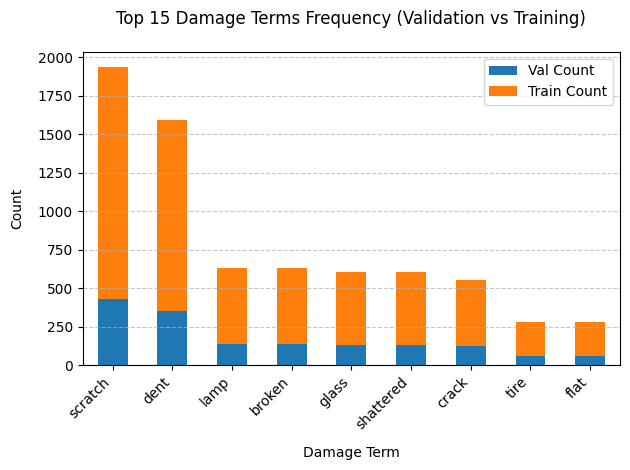


Top 15 Damage Terms for Prompt Engineering:
['scratch', 'dent', 'lamp', 'broken', 'glass', 'shattered', 'crack', 'tire', 'flat']


In [27]:
# import pandas as pd
# from collections import Counter
# import nltk
# from nltk.tokenize import word_tokenize
# import matplotlib.pyplot as plt

# nltk.download('punkt')

# # Load both datasets
# val_df = pd.read_csv("/kaggle/input/tammathon-task-3/val.csv")
# train_df = pd.read_csv("/kaggle/input/tammathon-task-3/train.csv")

# # Words to ignore (add more as needed)
# IGNORE_WORDS = {
#     'car', 'image', 'with', 'shows', 'visible', 'damage', 
#     'no', 'and', 'on', 'the', 'a', 'an', 'in', 'of', 'to'
# }

# def extract_damage_words(text):
#     if not isinstance(text, str):
#         return []
    
#     # Remove the standard prefix
#     text = text.lower()
#     for prefix in ['car image with', 'car image shows', 'image of car with']:
#         text = text.replace(prefix, '')
    
#     # Tokenize and filter
#     words = word_tokenize(text)
#     return [word for word in words 
#             if word.isalpha() 
#             and word not in IGNORE_WORDS 
#             and len(word) > 2]

# # Process both datasets using 'caption' column
# val_words = []
# for desc in val_df['caption']:
#     val_words.extend(extract_damage_words(desc))

# train_words = []
# for desc in train_df['caption']:
#     train_words.extend(extract_damage_words(desc))

# # Get top terms
# val_counts = Counter(val_words)
# train_counts = Counter(train_words)

# # Create comparison table
# top_terms = set(list(dict(val_counts.most_common(20)).keys()) + 
#                list(dict(train_counts.most_common(20)).keys()))

# comparison_table = []
# for term in top_terms:
#     comparison_table.append({
#         'Term': term,
#         'Val Count': val_counts.get(term, 0),
#         'Train Count': train_counts.get(term, 0),
#         'Total': val_counts.get(term, 0) + train_counts.get(term, 0)
#     })

# # Create and display dataframe
# terms_df = pd.DataFrame(comparison_table).sort_values('Total', ascending=False)
# print("Top Damage Terms Across Datasets:")
# display(terms_df.head(20))

# # Save to CSV
# terms_df.to_csv("/kaggle/working/damage_term_frequency.csv", index=False)

# # Visualization
# plt.figure(figsize=(14, 7))
# terms_df.head(15).set_index('Term')[['Val Count', 'Train Count']].plot(
#     kind='bar', 
#     stacked=True,
#     color=['#1f77b4', '#ff7f0e']
# )
# plt.title("Top 15 Damage Terms Frequency (Validation vs Training)", pad=20)
# plt.ylabel("Count", labelpad=10)
# plt.xlabel("Damage Term", labelpad=10)
# plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.savefig("/kaggle/working/damage_term_distribution.png", dpi=300, bbox_inches='tight')
# plt.show()

# # Print most common terms for prompt engineering
# top_15_terms = terms_df['Term'].head(15).tolist()
# print("\nTop 15 Damage Terms for Prompt Engineering:")
# print(top_15_terms)

# Creating Submission.csv

For testing, ignore for submission

In [30]:
import os
import pandas as pd
import base64
from openai import OpenAI
from tqdm import tqdm
import time
import json
from tenacity import retry, stop_after_attempt, wait_exponential

# Configuration
API_CALL_DELAY = 1.5  # Delay between API calls
MAX_RETRIES = 3  # Maximum retry attempts
TEST_SAMPLE_SIZE = 5  # Number of images to test
LOG_FILE = "/kaggle/working/api_logs.jsonl"  # Log file path

# Initialize OpenAI client
# client = OpenAI(api_key="your_openai_api_key")  # Replace with your key

# Define allowed damage terms
ALLOWED_DAMAGE_TERMS = [
    'scratch', 'dent', 'lamp', 'broken', 'glass',
    'shattered', 'crack', 'tire', 'flat'
]

# Strict format system prompt
SYSTEM_PROMPT = f"""
You are a professional car damage assessor. Analyze the image and:

**Strict Requirements:**
1. Only use these damage terms: {", ".join(ALLOWED_DAMAGE_TERMS)}
2. Respond EXACTLY in format: "Car image with [damage1], [damage2]..."
3. Separate multiple damages with commas
4. Use ONLY the specified terms - no variations
5. If no damage: "Car image with no visible damage"

**Examples:**
- "Car image with scratch, dent"
- "Car image with broken glass"
- "Car image with flat tire"
- "Car image with no visible damage"

**Important:**
- Do not add locations or severity
- Do not use other words besides the specified terms
- Keep it to one short sentence
"""

def encode_image(image_path):
    """Encode image to base64"""
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except Exception as e:
        print(f"Image encoding failed for {image_path}: {str(e)}")
        return None

@retry(stop=stop_after_attempt(MAX_RETRIES),
       wait=wait_exponential(multiplier=1, min=4, max=10))
def get_damage_description(image_path, client, log_file=None):
    """Get damage description with strict formatting"""
    try:
        base64_image = encode_image(image_path)
        if not base64_image:
            return None

        response = client.chat.completions.create(
            model="gpt-4-vision-preview",
            messages=[
                {
                    "role": "system",
                    "content": SYSTEM_PROMPT
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": "Analyze this car image for damages."
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}",
                                "detail": "high"
                            }
                        }
                    ]
                }
            ],
            temperature=0.0,  # Minimize creativity for strict format
            max_tokens=100,
        )

        description = response.choices[0].message.content.strip()
        
        # Validate response format
        if not description.startswith("Car image with"):
            description = "Car image with " + description
        
        # Log the response
        if log_file:
            log_entry = {
                "image": os.path.basename(image_path),
                "response": description,
                "timestamp": pd.Timestamp.now().isoformat()
            }
            with open(log_file, "a") as f:
                f.write(json.dumps(log_entry) + "\n")

        return description

    except Exception as e:
        print(f"API call failed for {os.path.basename(image_path)}: {str(e)}")
        if log_file:
            with open(log_file, "a") as f:
                f.write(json.dumps({
                    "image": os.path.basename(image_path),
                    "error": str(e),
                    "timestamp": pd.Timestamp.now().isoformat()
                }) + "\n")
        raise

# Load validation data
VAL_CSV_PATH = "/kaggle/input/tammathon-task-3/val.csv"
VAL_IMAGE_PATH = "/kaggle/input/tammathon-task-3/val/val"
val_df = pd.read_csv(VAL_CSV_PATH)

# Process images
predictions = []
for idx, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Processing"):
    try:
        img_path = os.path.join(VAL_IMAGE_PATH, row['file_name'])
        description = get_damage_description(img_path, client, LOG_FILE)
        predictions.append(description or "Format error")
    except Exception as e:
        predictions.append(f"Error: {str(e)}")
    time.sleep(API_CALL_DELAY)

# Create results dataframe
results_df = pd.DataFrame({
    'id': val_df['id'],
    'file_name': val_df['file_name'],
    'prediction': predictions
})

# Save results
results_df.to_csv("/kaggle/working/damage_predictions.csv", index=False)
print("\nResults saved. Sample predictions:")
print(results_df[['id', 'prediction']].head())

Processing:  47%|████▋     | 379/810 [32:08<36:32,  5.09s/it]  


KeyboardInterrupt: 

In [29]:
import pandas as pd
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')

# Load your predictions and ground truth
predictions_df = pd.read_csv("/kaggle/working/damage_predictions.csv")
val_df = pd.read_csv("/kaggle/input/tammathon-task-3/val.csv")

# Merge the dataframes
merged_df = pd.merge(
    predictions_df, 
    val_df[['id', 'caption']], 
    on='id', 
    how='left'
).rename(columns={'caption': 'ground_truth'})

# Display first 15 side-by-side comparisons
print("\nSide-by-Side Comparison (First 15 Samples):")
display(merged_df[['id', 'ground_truth', 'prediction']])

# Preprocess text for METEOR scoring
def preprocess(text):
    return word_tokenize(str(text).lower())

# Calculate METEOR scores
meteor_scores = []
for _, row in merged_df.iterrows():
    gt = preprocess(row['ground_truth'])
    pred = preprocess(row['prediction'])
    score = meteor_score([gt], pred)
    meteor_scores.append(score)

# Add scores to dataframe
merged_df['meteor_score'] = meteor_scores

# Calculate statistics
mean_meteor = merged_df['meteor_score'].mean()
std_meteor = merged_df['meteor_score'].std()

print("\nMETEOR Evaluation Results:")
print(f"Mean Score: {mean_meteor:.4f}")
print(f"Standard Deviation: {std_meteor:.4f}")

# Show best and worst matches
print("\nTop 3 Best Matches (Highest METEOR):")
display(merged_df.nlargest(3, 'meteor_score')[['ground_truth', 'prediction', 'meteor_score']])

print("\nTop 3 Worst Matches (Lowest METEOR):")
display(merged_df.nsmallest(3, 'meteor_score')[['ground_truth', 'prediction', 'meteor_score']])

# Save full results with scores
results_path = "/kaggle/working/prediction_evaluation.csv"
merged_df.to_csv(results_path, index=False)
print(f"\nFull evaluation results saved to {results_path}")

# Additional analysis: Exact match percentage
merged_df['exact_match'] = merged_df['ground_truth'].str.lower() == merged_df['prediction'].str.lower()
exact_match_rate = merged_df['exact_match'].mean()
print(f"\nExact Match Rate: {exact_match_rate:.1%}")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...



Side-by-Side Comparison (First 15 Samples):


[nltk_data]   Package wordnet is already up-to-date!


,id,ground_truth,prediction
0,13,"Car image with flat tire, crack, shattered glass.","Car image with shattered glass, flat tire."
1,16,"Car image with dent, scratch.",Car image with scratch.
2,17,Car image with scratch.,Car image with scratch.
3,24,Car image with scratch.,"Car image with scratch, dent."
4,25,Car image with scratch.,"Car image with scratch, dent."



METEOR Evaluation Results:
Mean Score: 0.8662
Standard Deviation: 0.1224

Top 3 Best Matches (Highest METEOR):


,ground_truth,prediction,meteor_score
2,Car image with scratch.,Car image with scratch.,0.996000
3,Car image with scratch.,"Car image with scratch, dent.",0.930769
4,Car image with scratch.,"Car image with scratch, dent.",0.930769



Top 3 Worst Matches (Lowest METEOR):


,ground_truth,prediction,meteor_score
1,"Car image with dent, scratch.",Car image with scratch.,0.711765
0,"Car image with flat tire, crack, shattered glass.","Car image with shattered glass, flat tire.",0.761888
3,Car image with scratch.,"Car image with scratch, dent.",0.930769



Full evaluation results saved to /kaggle/working/prediction_evaluation.csv

Exact Match Rate: 20.0%


In [32]:
!print(f"{results_df}")

/bin/bash: -c: line 6: syntax error near unexpected token `$'f"   id   file_name                                  prediction\n0  13  000013.jpg  Car image with shattered glass, flat tire.\n1  16  000016.jpg                     Car image with scratch.\n2  17  000017.jpg                     Car image with scratch.\n3  24  000024.jpg               Car image with scratch, dent.\n4  25  000025.jpg               Car image with scratch, dent."''
/bin/bash: -c: line 6: `4  25  000025.jpg               Car image with scratch, dent.")'
